In [ ]:
!pip install google_play_scraper
!pip install textblob
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

<ipython-input-1-9ccb641008d5>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
#Android App YesDok link from Google Play at
#https://play.google.com/store/apps/details?id=com.yesdok.mobile.app&hl=id
#The apps ID found in the link after id=com.yesdok.mobile.app&hl=id
#The apps name on Google Play titled: YesDok by YesDok
#Dated 8 September 2024: number of reviews 16k

from google_play_scraper import app, Sort, reviews_all

yesdok_reviews = reviews_all(
    'com.yesdok.mobile.app',
    sleep_milliseconds=0, # defaults to 0
    lang='id', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [ ]:
#Save the YesDok app reviews into dataframe
df_yesdokrev = pd.DataFrame(np.array(yesdok_reviews),columns=['content'])
df_yesdokrev = df_yesdokrev.join(pd.DataFrame(df_yesdokrev.pop('content').tolist()))
df_yesdokrev.to_csv(r'review_yesdok_raw.csv', index=False)
df_yesdokrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,2bb04eab-717b-4055-9db7-f38ef60ecba0,Debby Sintia,https://play-lh.googleusercontent.com/a-/ALV-U...,"Gak bisa bayar yg mau di bpilih , bingung aneh...",2,0,12.2.4,2024-07-15 09:19:36,None,NaT,12.2.4
1,d3e5d6bb-3994-4e78-986c-031f8f03f1f2,Pangersa Sayyid Baher Albantani,https://play-lh.googleusercontent.com/a-/ALV-U...,Sgt berguna utk tahu kesehatan dan shared soal...,5,0,12.2.4,2024-07-14 16:08:45,None,NaT,12.2.4
2,d9600cfa-93c1-4c85-9884-0adc5002d9d4,Puji Wulandari,https://play-lh.googleusercontent.com/a-/ALV-U...,Sudah war jadwal dokter berbulan2 pas hari H d...,1,0,12.2.3,2024-07-02 08:11:52,None,NaT,12.2.3
3,394f32b5-40b6-4bf6-be29-f04a9b8d2f81,Restu Hendri Sulistyawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dokternya sibuk terus,1,1,12.2.1,2024-05-17 05:37:42,None,NaT,12.2.1
4,ad828567-8e95-46e5-bada-04cbf442c946,Dita Nilawati,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi yang sangat kurang relevan buat dipak...,1,1,None,2024-05-04 00:07:21,None,NaT,None


In [ ]:
#Information on the table
df_yesdokrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11674 entries, 0 to 11673
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              11674 non-null  object        
 1   userName              11674 non-null  object        
 2   userImage             11674 non-null  object        
 3   content               11674 non-null  object        
 4   score                 11674 non-null  int64         
 5   thumbsUpCount         11674 non-null  int64         
 6   reviewCreatedVersion  6700 non-null   object        
 7   at                    11674 non-null  datetime64[ns]
 8   replyContent          939 non-null    object        
 9   repliedAt             939 non-null    datetime64[ns]
 10  appVersion            6700 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1003.4+ KB


In [ ]:
print(df_yesdokrev.reviewCreatedVersion.unique())
print(df_yesdokrev.reviewCreatedVersion.nunique())

['12.2.4' '12.2.3' '12.2.1' None '12.1.3' '12.2.0' '11.2.5' '11.2.3'
 '11.2.1' '11.2.0' '11.1.6' '11.1.5' '11.1.3' '11.1.2' '11.1.1' '11.1.0'
 '11.0.9' '11.0.8' '11.0.7' '11.0.5' '11.0.4' '11.0.3' '11.0.2' '9.2.8'
 '11.0.1' '11.0.0' '10.1.1' '10.0.25' '10.0.16' '10.0.23' '10.0.20'
 '10.0.18' '10.0.12' '10.0.9' '10.0.11' '10.0.10' '10.0.7' '10.0.6'
 '10.0.5' '9.5.5' '9.5.4' '9.5.3' '9.5.2' '9.5.1' '9.2.1' '9.5.0' '9.4.5'
 '9.4.9' '9.4.8' '9.4.7' '9.4.6' '9.4.3' '9.3.3' '9.4.4' '9.3.2' '9.4.2'
 '9.4.1' '9.4.0' '9.3.8' '8.2.9' '9.3.1' '8.3.0' '9.2.4' '9.3.0' '9.2.9'
 '9.2.7' '9.2.5' '9.2.6' '9.2.3' '9.2.0' '8.3.4' '9.1.9' '9.1.8' '9.1.7'
 '9.1.5' '9.1.4' '9.1.6' '9.1.3' '9.1.2' '9.1.0' '9.0.9' '9.0.8' '8.4.3'
 '9.0.7' '9.0.6' '9.0.5' '9.0.4' '9.0.1' '9.0.3' '9.0.2' '9.0.0av' '8.4.2'
 '8.3.9' '8.3.8' '8.4.1' '8.3.7' '8.3.6' '8.3.3b' '8.3.2' '8.2.4' '8.2.8'
 '5.3.4' '8.2.6' '8.2.0' '8.2.7' '5.0.9' '7.4.6' '8.2.3' '8.2.2' '8.2.1'
 '8.1.9' '7.3.9' '8.1.8' '8.1.6' '8.1.1' '8.1.5' '8.1.4' '8.0.

In [ ]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_yesdokrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,"Gak bisa bayar yg mau di bpilih , bingung aneh...",2,0,12.2.4,2024-07-15 09:19:36,None,NaT
1,Sgt berguna utk tahu kesehatan dan shared soal...,5,0,12.2.4,2024-07-14 16:08:45,None,NaT
2,Sudah war jadwal dokter berbulan2 pas hari H d...,1,0,12.2.3,2024-07-02 08:11:52,None,NaT
3,Dokternya sibuk terus,1,1,12.2.1,2024-05-17 05:37:42,None,NaT
4,Aplikasi yang sangat kurang relevan buat dipak...,1,1,None,2024-05-04 00:07:21,None,NaT
...,...,...,...,...,...,...,...
11669,Sangat membantu.. Aplikasinya sangat bagus,5,0,None,2018-01-03 08:14:31,None,NaT
11670,Sangat membantu dalam konsultasi masalah keseh...,5,2,2.10,2017-12-23 15:32:57,None,NaT
11671,Bagus,5,0,None,2017-12-12 09:36:43,None,NaT
11672,Helpfully,5,2,1.0.7,2017-11-08 08:17:58,None,NaT


In [ ]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

In [ ]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_yesdokrev['sentiment_polarity'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).polarity)
df_yesdokrev['sentiment_subjective'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [ ]:
#df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,"Gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0
1,Sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0
2,Sudah war jadwal dokter berbulan2 pas hari H dokternya terkendala jaringan. Alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? Konsul g...,1,0.2,0.2
3,Dokternya sibuk terus,1,0.0,0.0
4,"Aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat BCA Dan berhasil ...",1,0.0,0.0
...,...,...,...,...
11669,Sangat membantu.. Aplikasinya sangat bagus,5,0.0,0.0
11670,Sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0
11671,Bagus,5,0.0,0.0
11672,Helpfully,5,0.0,0.0


In [ ]:
#Check number of reviews scores
df_yesdokrev['score'].value_counts()

,count
score,
5,11155
4,230
3,124
1,118
2,47


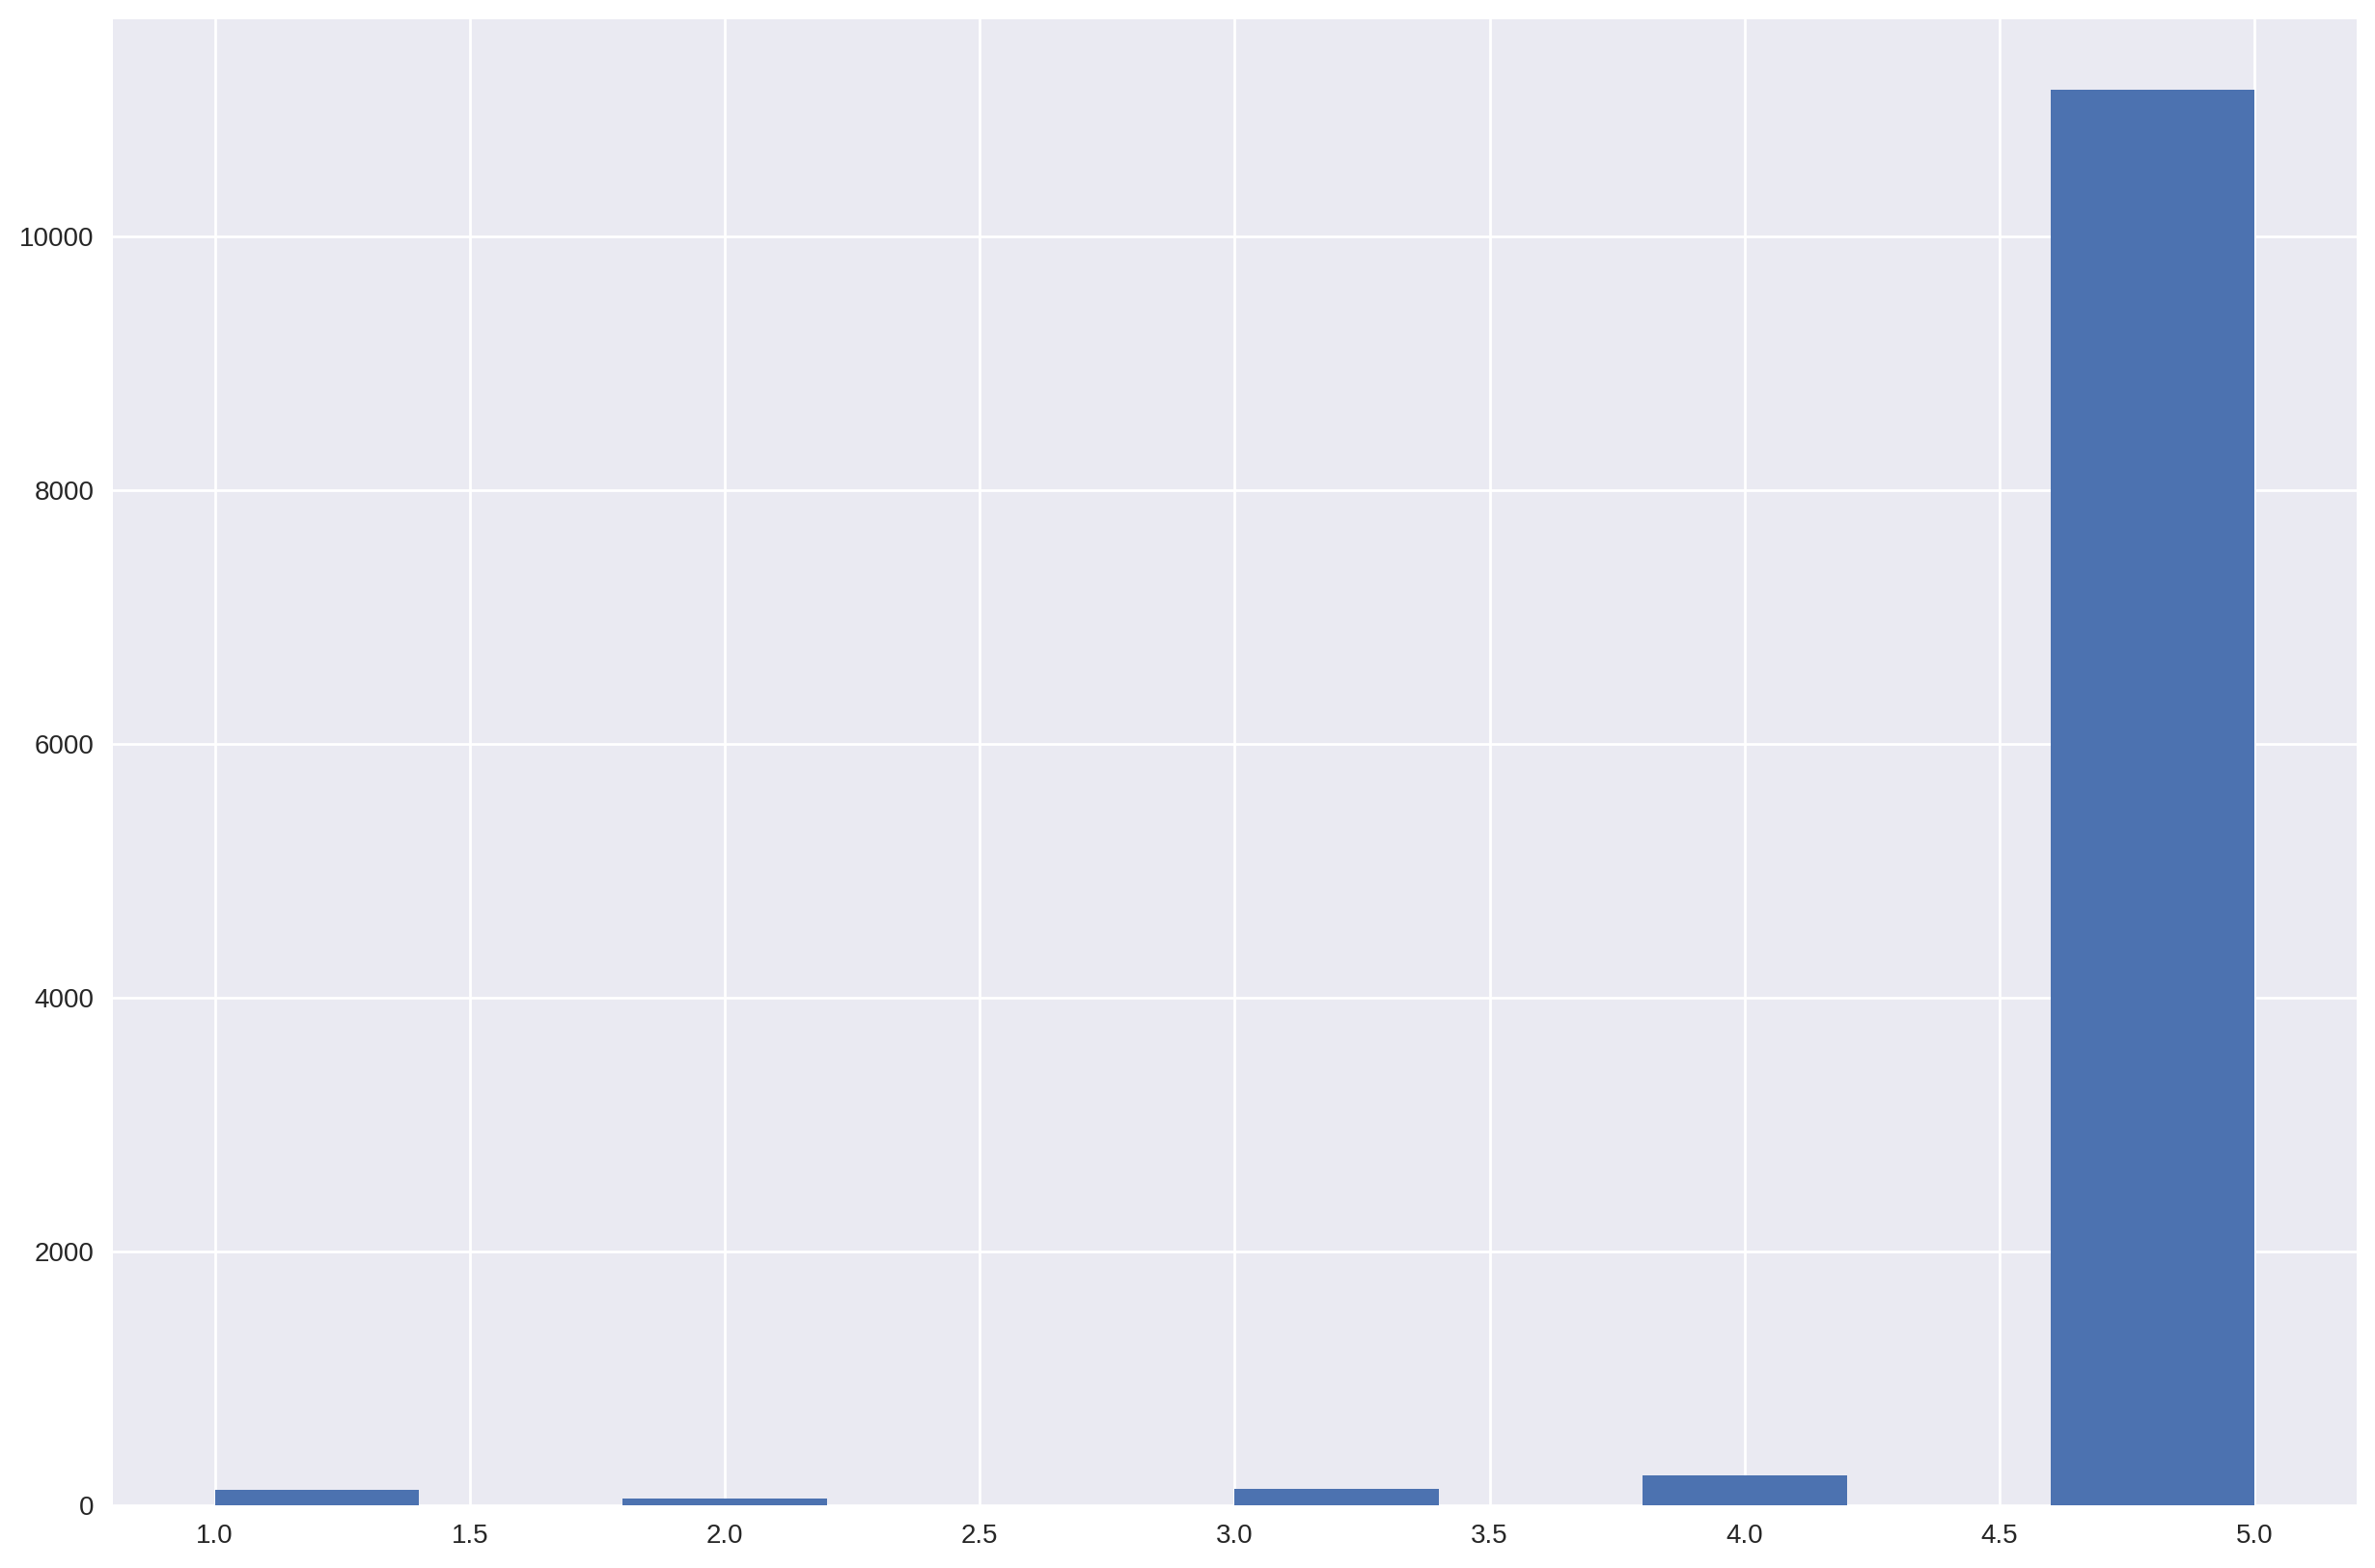

In [ ]:
plt.hist(df_yesdokrev['score'])
plt.show()

In [ ]:
#DATA PREPROCESSING
# Lower casing

# Change the reviews type to string
df_yesdokrev['content'] = df_yesdokrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_yesdokrev['content'][1766])

Cara nebus obatnya gimana yh?


In [ ]:
#Lowercase all reviews to see the difference
df_yesdokrev['content']= df_yesdokrev['content'].apply(lambda x: x.lower())
print(df_yesdokrev['content'][1766])

cara nebus obatnya gimana yh?


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_yesdokrev['wordCount'] = [len(review.split()) for review in df_yesdokrev['content']]

df_yesdokrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_yesdokrev['content']]

df_yesdokrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_yesdokrev['content']]

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,15,0,1
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,9,0,0
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,60,0,13
3,dokternya sibuk terus,1,0.0,0.0,3,0,0
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,73,0,6
...,...,...,...,...,...,...,...
11669,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,5,0,2
11670,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,13,0,0
11671,bagus,5,0.0,0.0,1,0,0
11672,helpfully,5,0.0,0.0,1,0,0


In [ ]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

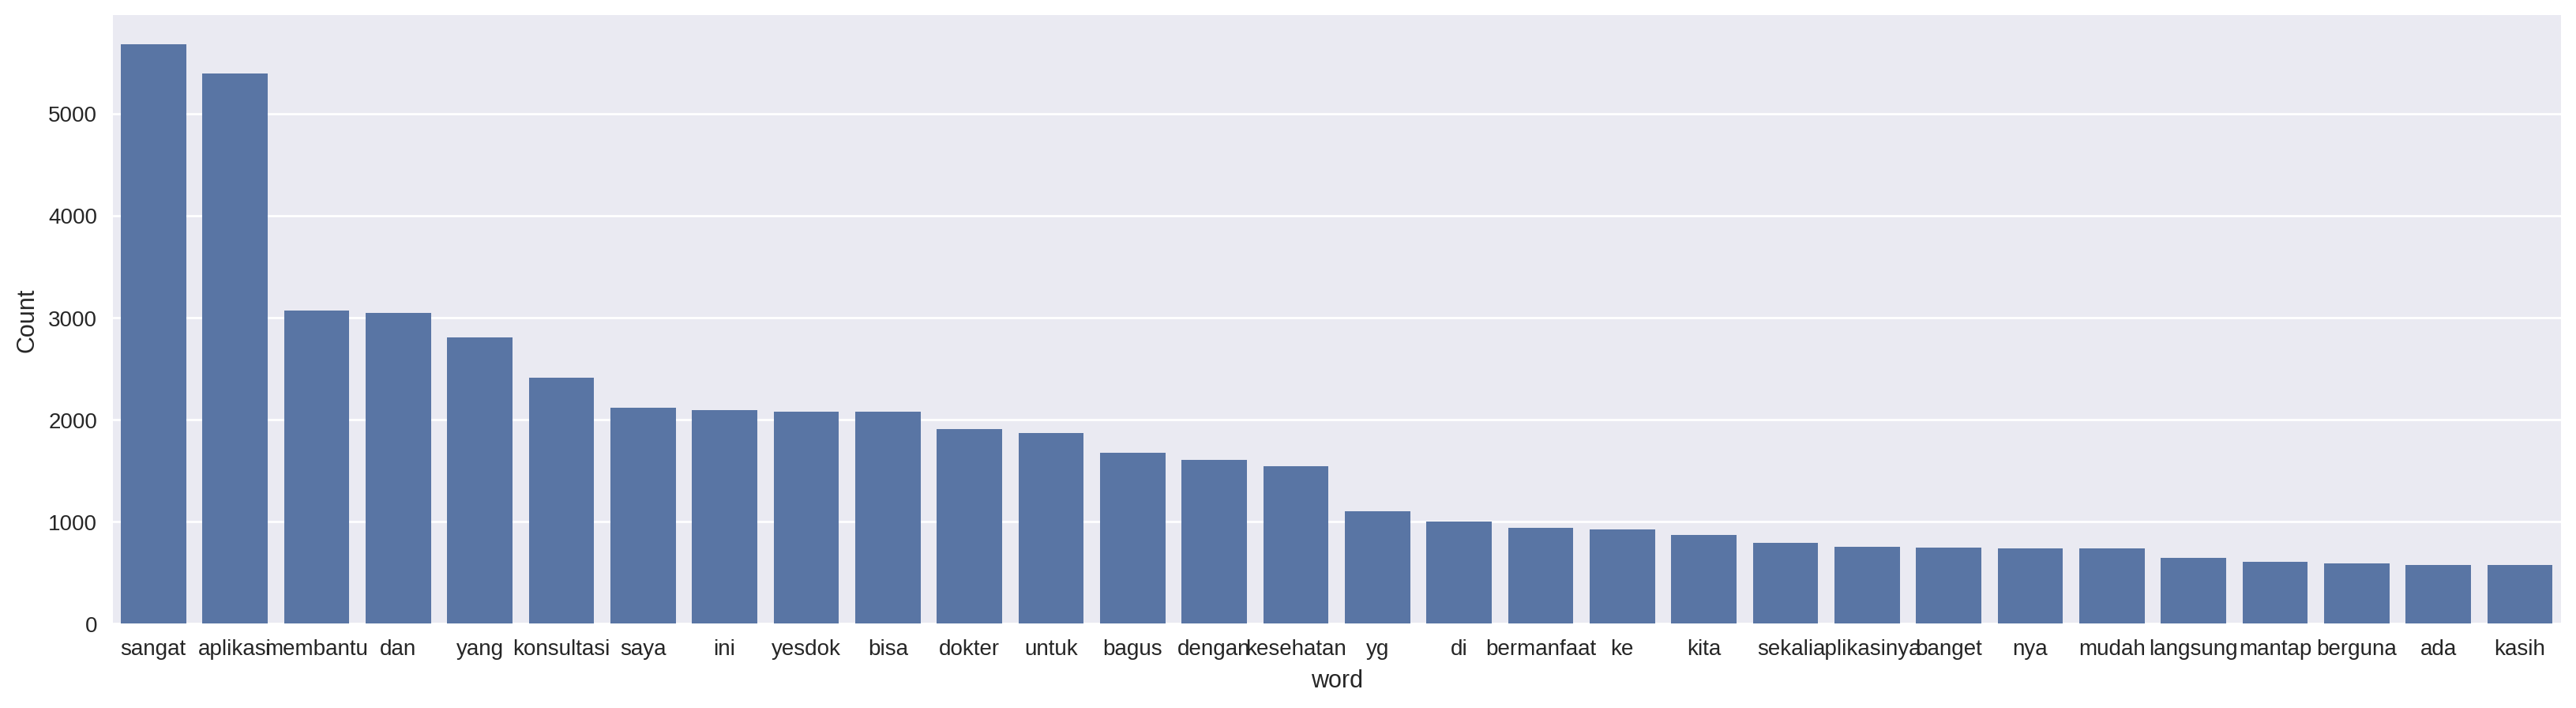

In [ ]:
freq_words(df_yesdokrev['content'])

In [ ]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_yesdokrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_yesdokrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙏', '🙏', '😁']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😇', '😇', '😇']", "['👍']", '[]', '[]', "['😠', '😠', '😠', '😠', '😡', '😡', '😡', '😡']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '👍']", '[]', '[]', '[]', "['🙏']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😉']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🥰', '🥰']", '[]', '[]', "['👍']", "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", "['😁']", '[]', '[]', '[]', '[]', "['👍', '🏻']", '[]', "['🥺', '🤲', '🕊']", '[]', "['👍', '👍']", '[]', '[]', '[]', "['🥰']", "['🥰']", '[]', '[]', '[]', '[]', "['😘', '😘']", '[]', '[]', '[]', "['🥰']", '[]', '[]', "['😭', '🥳', '👏', '🤩', '🙏', '🥰']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '💖']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🥺', '🙄', '🙄', '🙄']", '[]', '[]', '[]', '[]', '[]', '

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,15,0,1
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,9,0,0
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,60,0,13
3,dokternya sibuk terus,1,0.0,0.0,3,0,0
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,73,0,6
...,...,...,...,...,...,...,...
11669,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,5,0,2
11670,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,13,0,0
11671,bagus,5,0.0,0.0,1,0,0
11672,helpfully,5,0.0,0.0,1,0,0


In [ ]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_yesdokrev['sentiment_rating'] = df_yesdokrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,Negative
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,Positive
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,Negative
3,dokternya sibuk terus,1,0.0,0.0,Negative
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,Negative
...,...,...,...,...,...
11669,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,Positive
11670,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,Positive
11671,bagus,5,0.0,0.0,Positive
11672,helpfully,5,0.0,0.0,Positive


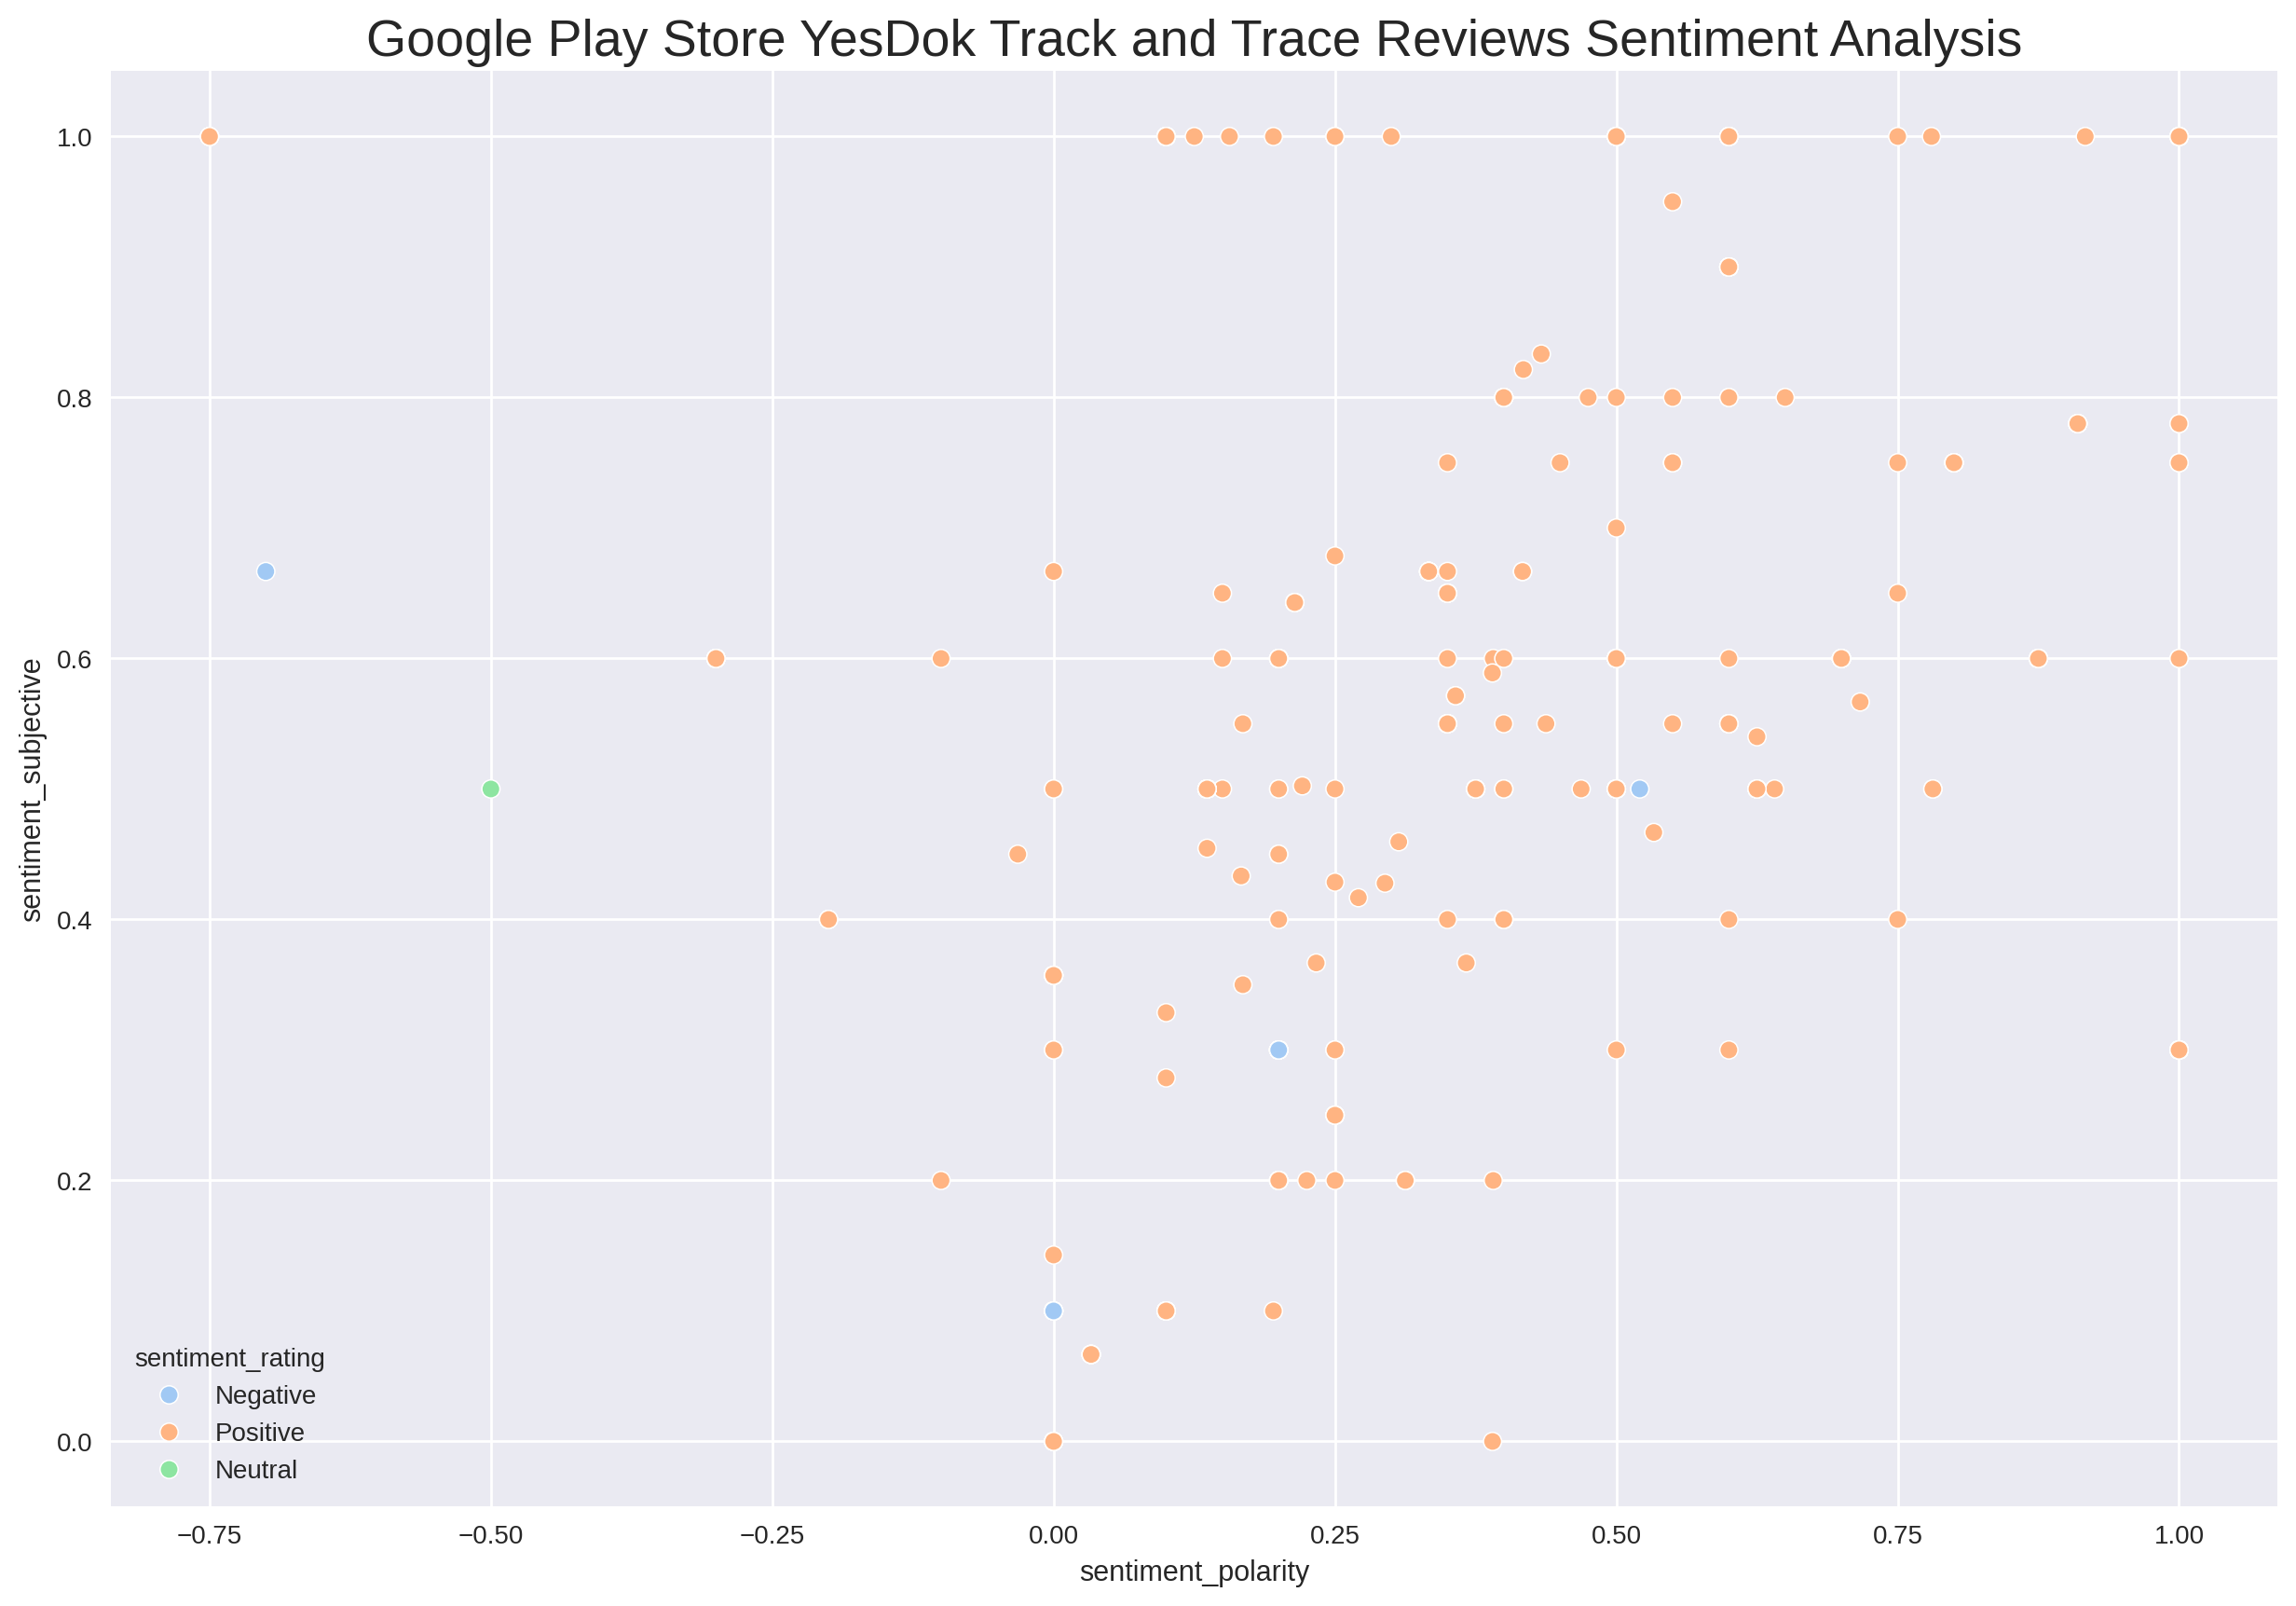

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# sns.scatterplot(df_yesdokrev['sentiment_polarity'], df_yesdokrev['sentiment_subjective'],
#                 hue = df_yesdokrev['sentiment_rating'], edgecolor='white', palette="pastel")
# plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Use the 'data' argument to pass the DataFrame and specify 'x' and 'y' within the function call
sns.scatterplot(data=df_yesdokrev, x='sentiment_polarity', y='sentiment_subjective',
                hue='sentiment_rating', edgecolor='white', palette="pastel")

plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
plt.show()

Stopwords

In [ ]:
print(df_yesdokrev.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'sentiment_polarity', 'sentiment_subjective',
       'wordCount', 'uppercaseCharCount', 'specialCharCount',
       'sentiment_rating'],
      dtype='object')


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan stopwords dan tokenizer sudah diunduh
nltk.download('stopwords')
nltk.download('punkt')

# Fungsi untuk menghapus stopwords
def remove_stopwords(text, stop_words):
    tokens = nltk.word_tokenize(text)  # Menggunakan nltk untuk tokenisasi
    tokens = [word for word in tokens if word.lower() not in stop_words]  # Menghapus stopwords
    return ' '.join(tokens)

# Fungsi untuk menghapus karakter non-alfabet
def remove_non_alpha(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Terapkan fungsi penghapusan emoji
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')


df_yesdokrev['content'] = df_yesdokrev['content'].apply(remove_emoji)

stop_words = set(stopwords.words('indonesian') + [
    "'", ",", ".", "yg", "banget", "bgt", "sih","kok", "loh", "lo", "gimana", "nih", "deh", "dong"
])

# Tokenisasi dan pengolahan teks
df_yesdokrev['review_tokenized'] = df_yesdokrev['content'].apply(lambda x: ' '.join(nltk.word_tokenize(x)))  # Tokenisasi
df_yesdokrev['review_with_stopwords'] = df_yesdokrev['review_tokenized'] \
    .apply(lambda x: remove_emoji(x)) \
    .apply(lambda x: remove_stopwords(x, stop_words)) \
    .apply(remove_non_alpha)

# Hitung jumlah kata sebelum dan sesudah penghapusan stopwords
df_yesdokrev['wordCount'] = df_yesdokrev['review_tokenized'].apply(lambda x: len(x.split()))
df_yesdokrev['wordCount_after_stopwords'] = df_yesdokrev['review_with_stopwords'].apply(lambda x: len(x.split()))

# Simpan DataFrame dengan hasil penghapusan stopwords
df_yesdokrev.to_csv(r'df_yesdok_stopwords.csv', index=False)

# Tampilkan DataFrame setelah penghapusan stopwords
print(df_yesdokrev.loc[:, ["content", "review_tokenized", "review_with_stopwords", "wordCount", "wordCount_after_stopwords"]])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                                                                                                                                                                       content  \
0                                                                                                                                    gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali   
1                                                                                                                                                     sgt berguna utk tahu kesehatan dan shared soal kesehatan   
2      sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...   
3                                                                                                                                                               

In [ ]:
# Load DataFrame dari file CSV yang telah diproses
df_yesdokrev_stopwords = pd.read_csv(r'df_yesdok_stopwords.csv')

# Menghapus baris yang mengandung nilai NaN di kolom 'content'
df_yesdokrev_stopwords = df_yesdokrev_stopwords.dropna(subset=['content'])

In [ ]:
# Tampilkan DataFrame
df_yesdokrev_stopwords.loc[:, ["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating", "wordCount", "review_with_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating,wordCount,review_with_stopwords,wordCount_after_stopwords
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,Negative,15,gak bayar bpilih bingung aneh gak bantuan sma,8
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,Positive,9,sgt berguna utk kesehatan shared kesehatan,6
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,Negative,66,war jadwal dokter berbulan pas h dokternya terkendala jaringan alhasil uang direfund masuk saldo yesdok ditf rekening potongan k rugi konsul ga uang kepotong lihat kecewa menyesal ya kasih bint...,38
3,dokternya sibuk terus,1,0.0,0.0,Negative,3,dokternya sibuk,2
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,Negative,77,aplikasi relevan dipake pelayanan yesdok bermanfaatsaya kecewa marah transfer bca berhasil giliran konsul dokternya sibuk gak tersambung coba hasilnya dikemudian samasemoga kedepannya yesdok yesdo...,28
...,...,...,...,...,...,...,...,...
11669,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,Positive,6,membantu aplikasinya bagus,3
11670,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,Positive,13,membantu konsultasi kesehatan bertatap lngsung dokter via vcall,8
11671,bagus,5,0.0,0.0,Positive,1,bagus,1
11672,helpfully,5,0.0,0.0,Positive,1,helpfully,1


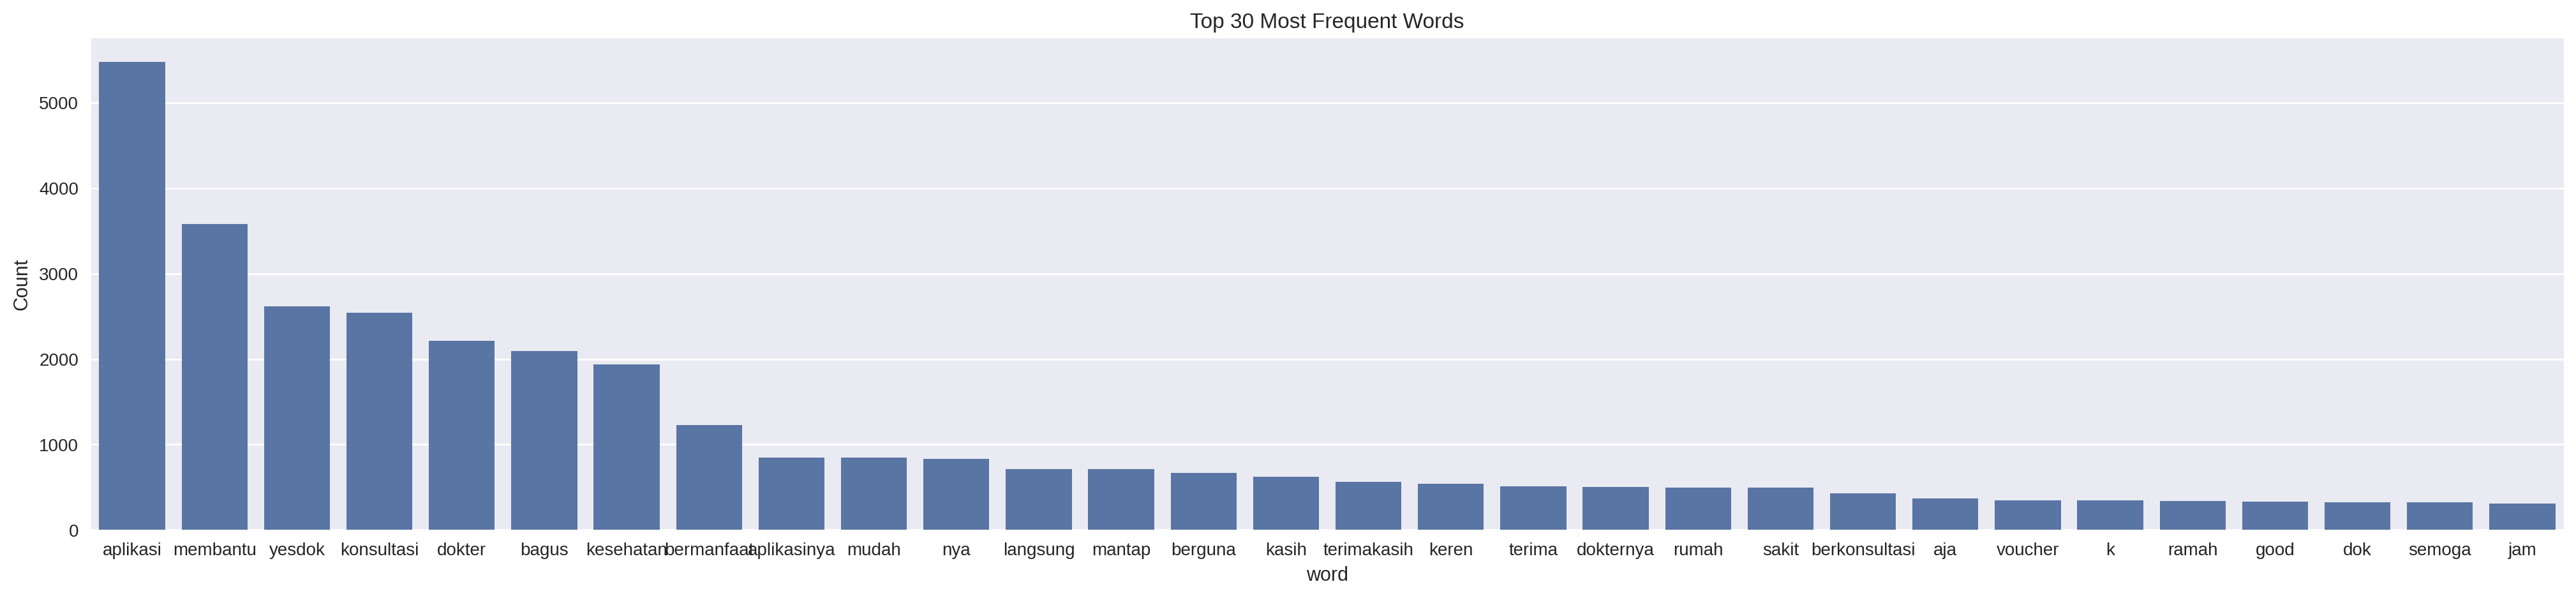

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist

# Function to plot the most frequent terms
def freq_words(x, terms=30):
    # Combine all text in column x into a large string
    all_words = ' '.join([str(text) for text in x if isinstance(text, str)])
    all_words = all_words.split()

    # Count word frequency
    fdist = FreqDist(all_words)

    # Create a DataFrame from the word frequencies
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Select the most frequent words
    d = words_df.nlargest(columns="count", n=terms)

    # Plot bar chart
    plt.figure(figsize=(25, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.title(f"Top {terms} Most Frequent Words")
    plt.show()

# Apply the function to the 'review_with_stopwords' column
freq_words(df_yesdokrev_stopwords['review_with_stopwords'])


Stemming

In [ ]:
# pip install Sastrawi

In [ ]:
# import pandas as pd
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# # Membuat stemmer
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# # Fungsi untuk stemming
# def stem_text(text):
#     return ' '.join([stemmer.stem(word) for word in text.split()])

# # Terapkan stemming pada kolom 'review_cleaned'
# df_yesdokrev_stopwords['review_stemmed'] = df_yesdokrev_stopwords['review_with_stopwords'].apply(stem_text)

# # Tampilkan DataFrame dengan kolom yang telah di-stemming
# print(df_yesdokrev_stopwords[['review_with_stopwords', 'review_stemmed']].head())


In [ ]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Create a stemmer using NLTK's PorterStemmer
stemmer = PorterStemmer()

# Function to perform stemming
def stem_text(text):
    # Tokenize the text and stem each word
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

# Assuming 'df_yesdokrev_stopwords' has a column 'review_with_stopwords'
# Fill NaN values with an empty string and apply stemming on the 'review_with_stopwords' column
df_yesdokrev_stopwords['review_with_stopwords'] = df_yesdokrev_stopwords['review_with_stopwords'].fillna("")
df_yesdokrev_stopwords['review_stemmed'] = df_yesdokrev_stopwords['review_with_stopwords'].apply(stem_text)

# Display the DataFrame with the original and stemmed columns
print(df_yesdokrev_stopwords[['review_with_stopwords', 'review_stemmed']].head())



                                                                                                                                                                                     review_with_stopwords  \
0                                                                                                                                                            gak bayar bpilih bingung aneh gak bantuan sma   
1                                                                                                                                                               sgt berguna utk kesehatan shared kesehatan   
2  war jadwal dokter berbulan pas h dokternya terkendala jaringan alhasil uang direfund masuk saldo yesdok ditf rekening potongan k  rugi  konsul ga uang kepotong  lihat kecewa menyesal ya kasih bint...   
3                                                                                                                                                                               

In [ ]:
df_yesdokrev_stopwords.loc[:,["content","score","sentiment_rating","wordCount","review_with_stopwords", "wordCount_after_stopwords","review_stemmed"]]

,content,score,sentiment_rating,wordCount,review_with_stopwords,wordCount_after_stopwords,review_stemmed
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,Negative,15,gak bayar bpilih bingung aneh gak bantuan sma,8,gak bayar bpilih bingung aneh gak bantuan sma
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,Positive,9,sgt berguna utk kesehatan shared kesehatan,6,sgt berguna utk kesehatan share kesehatan
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,Negative,66,war jadwal dokter berbulan pas h dokternya terkendala jaringan alhasil uang direfund masuk saldo yesdok ditf rekening potongan k rugi konsul ga uang kepotong lihat kecewa menyesal ya kasih bint...,38,war jadwal dokter berbulan pa h dokternya terkendala jaringan alhasil uang direfund masuk saldo yesdok ditf reken potongan k rugi konsul ga uang kepotong lihat kecewa menyes ya kasih bintang sayan...
3,dokternya sibuk terus,1,Negative,3,dokternya sibuk,2,dokternya sibuk
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,Negative,77,aplikasi relevan dipake pelayanan yesdok bermanfaatsaya kecewa marah transfer bca berhasil giliran konsul dokternya sibuk gak tersambung coba hasilnya dikemudian samasemoga kedepannya yesdok yesdo...,28,aplikasi relevan dipak pelayanan yesdok bermanfaatsaya kecewa marah transfer bca berhasil giliran konsul dokternya sibuk gak tersambung coba hasilnya dikemudian samasemoga kedepannya yesdok yesdok...
...,...,...,...,...,...,...,...
11669,sangat membantu.. aplikasinya sangat bagus,5,Positive,6,membantu aplikasinya bagus,3,membantu aplikasinya bagu
11670,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,Positive,13,membantu konsultasi kesehatan bertatap lngsung dokter via vcall,8,membantu konsultasi kesehatan bertatap lngsung dokter via vcall
11671,bagus,5,Positive,1,bagus,1,bagu
11672,helpfully,5,Positive,1,helpfully,1,help


In [ ]:
# Memilih kolom yang diinginkan
df_yesdok_stemmed = df_yesdokrev_stopwords.loc[:, ["content", "score", "sentiment_rating", "wordCount", "review_with_stopwords", "wordCount_after_stopwords", "review_stemmed"]]

# Menyimpan DataFrame ke CSV (opsional)
df_yesdok_stemmed.to_csv(r'df_yesdok_stemmed.csv', index=False)